In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
recent_date = session.query(func.max(Measurement.date)).all()[0][0]
recent_date
print(f"The most recent observation was made on {recent_date}.")

The most recent observation was made on 2017-08-23.


In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
      filter(Measurement.date < "2017-08-24").\
      filter(Measurement.date > "2016-08-23").\
        order_by(Measurement.date).\
        group_by(Measurement.date).\
        all()

# Save the query results as a Pandas DataFrame and set the index to the date column
Prec_df = pd.DataFrame(results, columns = ["Date", "Precipitation"])
Prec_df.set_index('Date', inplace=True) 
Prec_df

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


In [11]:
# Calculate the date one year from the last date in data set.
oneyear = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
oneyear

datetime.datetime(2016, 8, 23, 0, 0)

In [12]:
Prec_df = Prec_df.sort_index(ascending=True)
Prec_df

,Precipitation
Date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667
...,...
2017-08-19,0.030000
2017-08-20,0.005000
2017-08-21,0.193333


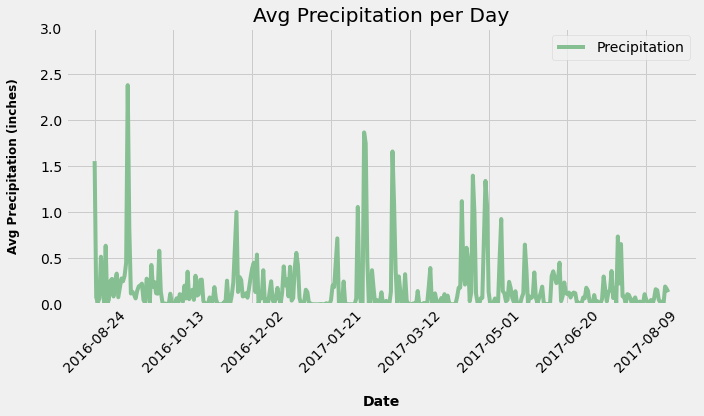

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data  #.get_figure()
ax = Prec_df.plot(title='Avg Precipitation per Day', rot=45, figsize=(10,6), color='#86bf91', zorder=2)

# Set x-axis label
ax.set_xlabel("Date", labelpad=20, weight='bold', size=14)

# Set y-axis label

ax.set_ylabel("Avg Precipitation (inches)", labelpad=20, weight='bold', size=12)
ax.set_ylim(0,3)

# Save image
ax.figure.tight_layout()
ax.figure.savefig("Images/Precipitation.png")

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
Prec_df.describe()

,Precipitation
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
number = session.query(Station)
print("There are {} weather stations in Hawaii.".format(number.count()))

There are 9 weather stations in Hawaii.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
stations = session.query(Measurement.station, func.count(Measurement.station)).\
        group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()

station1_name = ""
station1 = stations[0][0]

for location in number:
    if(location.station == stations[0][0]):
        station1_name = location.name 
print(f"The most active station: ")
print(f" Name    : {station1_name} ")
print(f" Station : {stations[0][0]}")
print(f" Count   : {stations[0][1]} observations")
print(" ")
print(" ")
print("List of the stations and their observation counts:")
print("  Station      Counts")
print("-----------------------")
for stations in stations:
    print(stations[0], "   ", stations[1])

The most active station: 
 Name    : WAIHEE 837.5, HI US 
 Station : USC00519281
 Count   : 2772 observations
 
 
List of the stations and their observation counts:
  Station      Counts
-----------------------
USC00519281     2772
USC00519397     2724
USC00513117     2709
USC00519523     2669
USC00516128     2612
USC00514830     2202
USC00511918     1979
USC00517948     1372
USC00518838     511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

temperature = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == station1).all()
print(f"The Lowest, Highest & the average temperature for the most active station {stations[0]} - {station1_name} is:")
print(f" Lowest Temperature  : {temperature[0][0]} F")
print(f" Highest Temperature: {temperature[0][1]} F")
print(f" Avg Temperature : {temperature[0][2]:.1f} F")

The Lowest, Highest & the average temperature for the most active station USC00518838 - WAIHEE 837.5, HI US is:
 Lowest Temperature  : 54.0 F
 Highest Temperature: 85.0 F
 Avg Temperature : 71.7 F


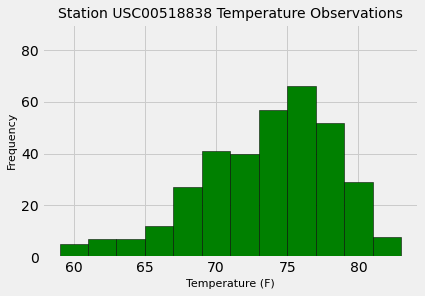

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_results = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == station1).filter(Measurement.date >= oneyear).\
    group_by(Measurement.date).all()

# Put data into dataframe so it can be plotted as histogram
temp_results_df = pd.DataFrame(data=temp_results, columns=["date", "tobs"])
temp_results_df = temp_results_df.set_index('date', drop=True)

# Plot the results as a histogram with bins=12
plt.hist(temp_results_df['tobs'],12, color = "green", ec="black")

# Formatting
plt.title("Station USC00518838 Temperature Observations", fontsize=14)
plt.ylabel("Frequency", fontsize=11)
plt.ylim((0,90))
plt.xlabel("Temperature (F)", fontsize=11)

plt.savefig("Images/Temperature Histogram.png")
plt.show()

# Close session

In [19]:
# Close Session
session.close()

# Climate App

In [20]:
# Dependencies

import datetime as dt

import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from flask import Flask, json, jsonify

In [21]:
# Use Flask to create the routes.
app = Flask(__name__)

In [22]:
# Routes   
# Home Page
@app.route("/")
def welcome():
    """List all available api routes."""
    return (
        f"Available Routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/<start><br/>"
        f"/api/v1.0/<start>/<end>"
    )


In [23]:
# Route: `/api/v1.0/precipitation`
# JSON representation of your dictionary.

@app.route("/api/v1.0/precipitation")
def prec():
    # Create our session (link) from Python to the DB
    session = Session(engine)

    # Convert the query results to a dictionary using `date` as the key and `prcp` as the value.
    results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date > oneyear).all()
    
    all_prcp = []
    
    for date_ob in results:
        all_prcp_dict = {}
        all_prcp_dict["Date"] = date_ob.date
        all_prcp_dict["Precipitation"] = date_ob.tobs

        all_prcp.append(all_prcp_dict)

    # Convert list of tuples into normal list
    prcp = list(np.ravel(results))

    return jsonify(prcp)

In [25]:
# `/api/v1.0/tobs`
#Query the dates and temperature observations of the most active station for the last year of data.
#Return a JSON list of temperature observations (TOBS) for the previous year.

#The most active station: 
# Station : USC00519281

results = session.query(Measurement.date, func.avg(Measurement.prcp)).\
      filter(Measurement.date < "2017-08-24").\
      filter(Measurement.date > "2016-08-23").\
        order_by(Measurement.date).\
        group_by(Measurement.date).\
        all()

@app.route('/api/v1.0/tobs/')
def tobs(): 
    # Find the most recent date in the data set.
    recent_date = session.query(func.max(Measurement.date)).all()[0][0]
    # Calculate the date one year from the last date in data set.
    oneyear = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

    temp_obs = session.query(Measurement.date, Measurement.tobs)\
        .filter(Measurement.date >= oneyear)\
        .filter(Measurement.station=="USC00519281")\
        .order_by(Measurement.date).all()
    
    
    return jsonify(temp_obs)


In [26]:
# Route:  `/api/v1.0/<start>`       
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start or start-end range.

@app.route("/api/v1.0/<start>")
def start1(start):
        
    select = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    result_temp = session.query(*select).\
        filter(Measurement.date >= start).all()
    
    return jsonify(result_temp)

In [27]:
# Route:  `/api/v1.0/<start>/<end>/`
# Return a JSON list of the minimum temperature, the average temperature, and the max temperature for a given start-end range.

@app.route("/api/v1.0/<start>/<end>")
def start_end1(start, end):
        
    select = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    result_temp = session.query(*select).\
        filter(Measurement.date >= start).filter(Measurement.date <= end).all()
    
    return jsonify(result_temp)


In [28]:
if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Restarting with windowsapi reloader


SystemExit: 1

C:\Users\danas\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3351: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
